In [1]:
# LOAD LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

# GLOBAL VARIABLES
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

2022-03-20 20:17:48.092238: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-20 20:17:48.092265: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# evaluate the deep model on the test dataset
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
 
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

x_train, y_train, x_valid, y_valid = load_dataset()
x_train, x_valid = prep_pixels(x_train, x_valid)

In [3]:
model = Sequential()
model.add(Conv2D(32,kernel_size=4,activation='relu',input_shape=(28,28,1)))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size=4,activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

2022-03-20 20:17:54.041228: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-20 20:17:54.041275: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-20 20:17:54.041314: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (paula-Inspiron-3459): /proc/driver/nvidia/version does not exist
2022-03-20 20:17:54.042567: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
import sys
  
sys.path.insert(0, '../')

from ipynb.fs.full.utils import save_weights,evaluate_layers_sensitivity, prune_layer_feature_maps

In [9]:
save_weights("intel_avxsse_model.txt", model)

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               1

# Training

In [4]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=5, verbose=1, validation_data=(x_valid, y_valid))

2022-03-20 20:17:59.816155: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/5
 454/1875 [======>.......................] - ETA: 23s - loss: 0.2912 - accuracy: 0.9096

KeyboardInterrupt: 

In [14]:
model.predict(x_valid[0:1])

array([[3.0818979e-11, 3.2254815e-10, 1.5381405e-08, 7.1379674e-10,
        5.4191423e-15, 5.6662727e-11, 4.5155552e-19, 1.0000000e+00,
        7.9666915e-12, 1.1928821e-08]], dtype=float32)

In [15]:
y_valid[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

## Prunning

layer: 0
remove: 1
313/313 [==============================] - 2s 6ms/step - loss: 0.0276 - accuracy: 0.9910
remove: 4
313/313 [==============================] - 2s 5ms/step - loss: 0.0280 - accuracy: 0.9912
remove: 7
313/313 [==============================] - 2s 5ms/step - loss: 0.0289 - accuracy: 0.9905
remove: 10
313/313 [==============================] - 2s 4ms/step - loss: 0.0354 - accuracy: 0.9895
remove: 13
313/313 [==============================] - 2s 5ms/step - loss: 0.0679 - accuracy: 0.9816
remove: 16
313/313 [==============================] - 1s 4ms/step - loss: 0.0516 - accuracy: 0.9861
remove: 19
313/313 [==============================] - 1s 4ms/step - loss: 0.3001 - accuracy: 0.8945
remove: 22
313/313 [==============================] - 2s 4ms/step - loss: 0.2433 - accuracy: 0.9236
remove: 25
313/313 [==============================] - 1s 4ms/step - loss: 0.6029 - accuracy: 0.7932
remove: 28
313/313 [==============================] - 1s 4ms/step - loss: 1.0525 - accuracy: 0

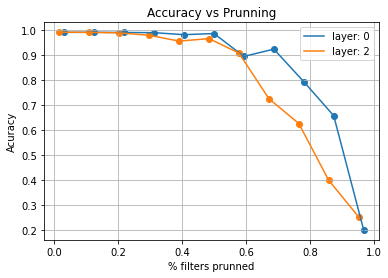

In [16]:
evaluate_layers_sensitivity(model, x_valid, y_valid)

In [17]:
# Prune first layer
model_prunned = prune_layer_feature_maps(model, 0, 19)
model_prunned.compile(loss = "categorical_crossentropy", metrics = ["accuracy"])
_, _ = model_prunned.evaluate(x_valid, y_valid)

313/313 [==============================] - 1s 4ms/step - loss: 0.3001 - accuracy: 0.8945


In [18]:
# retrain
_ = model_prunned.fit(x_train, y_train, epochs=3, verbose=1, validation_data=(x_valid, y_valid))

2022-03-15 18:28:08.144761: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/3
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0213 - accuracy: 0.9933 - val_loss: 0.0310 - val_accuracy: 0.9908
Epoch 2/3
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0170 - accuracy: 0.9951 - val_loss: 0.0361 - val_accuracy: 0.9902
Epoch 3/3
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0147 - accuracy: 0.9962 - val_loss: 0.0361 - val_accuracy: 0.9912


In [19]:
# Prune second layer
model_prunned_2 = prune_layer_feature_maps(model_prunned, 2, 37)
model_prunned_2.compile(loss = "categorical_crossentropy", metrics = ["accuracy"])
_, _ = model_prunned_2.evaluate(x_valid,  y_valid)

313/313 [==============================] - 1s 4ms/step - loss: 0.2758 - accuracy: 0.8985


In [20]:
# retrain
_ = model_prunned_2.fit(x_train, y_train, epochs=3, verbose=1, validation_data=(x_valid, y_valid))

Epoch 1/3


2022-03-15 18:29:28.097515: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0222 - accuracy: 0.9928 - val_loss: 0.0367 - val_accuracy: 0.9893
Epoch 2/3
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0173 - accuracy: 0.9944 - val_loss: 0.0327 - val_accuracy: 0.9909
Epoch 3/3
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0143 - accuracy: 0.9960 - val_loss: 0.0377 - val_accuracy: 0.9911


In [21]:
model_prunned_2.summary()

Model: "sequential_1090"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1424 (Conv2D)        (None, 25, 25, 13)        221       
                                                                 
 max_pooling2d_1424 (MaxPool  (None, 12, 12, 13)       0         
 ing2D)                                                          
                                                                 
 conv2d_1462 (Conv2D)        (None, 9, 9, 27)          5643      
                                                                 
 max_pooling2d_1462 (MaxPool  (None, 4, 4, 27)         0         
 ing2D)                                                          
                                                                 
 flatten_1090 (Flatten)      (None, 432)               0         
                                                                 
 dense_2180 (Dense)          (None, 128)           

In [22]:
model_prunned_2.evaluate(x_valid, y_valid)

313/313 [==============================] - 1s 4ms/step - loss: 0.0377 - accuracy: 0.9911


[0.03765968605875969, 0.991100013256073]

In [23]:
model.evaluate(x_valid, y_valid)

313/313 [==============================] - 2s 5ms/step - loss: 0.0275 - accuracy: 0.9911


[0.027544720098376274, 0.991100013256073]

In [24]:
save_weights("prunned_avxsse_model.orga", model_prunned_2)